In [6]:
!pip install pandas numpy yfinance statsmodels matplotlib


In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


Enter the stock ticker symbol (e.g., AAPL for Apple): AAPL
Enter the prediction date (YY-MM-DD): 24-12-06


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0896
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted price for AAPL on 2024-12-06: $216.26
Test Mean Squared Error (MSE): 204.38
Test Mean Absolute Error (MAE): 13.12
Test Root Mean Squared Error (RMSE): 14.30


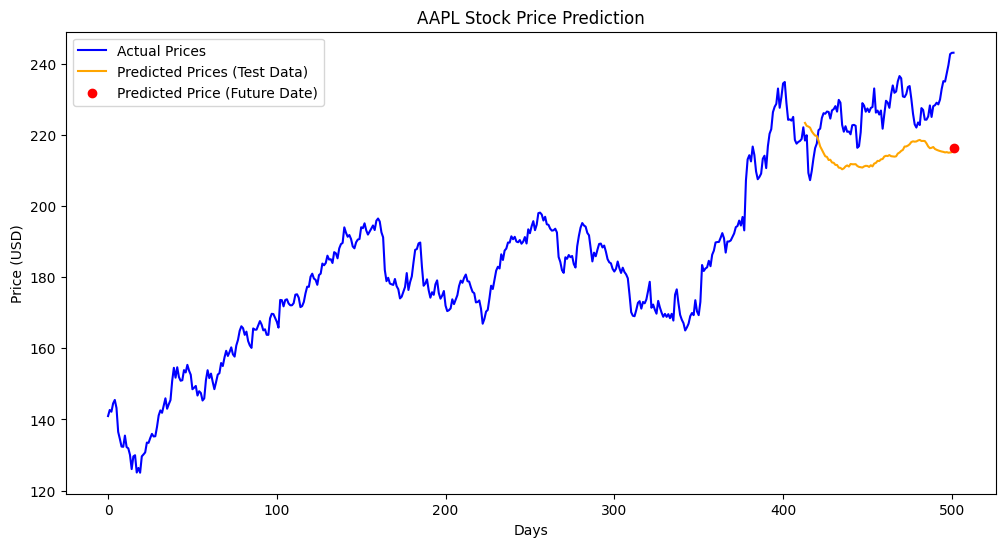

In [12]:
# Function to fetch stock data from Yahoo Finance
def get_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    return data

# User input for stock ticker and prediction date
ticker = input("Enter the stock ticker symbol (e.g., AAPL for Apple): ")
prediction_date_input = input("Enter the prediction date (YY-MM-DD): ")

# Convert the prediction date to a datetime object by adding '20' to the year
try:
    prediction_date = datetime.strptime('20' + prediction_date_input, "%Y-%m-%d").date()
except ValueError:
    print("Invalid date format. Please use the format 'YY-MM-DD'.")
    prediction_date = None

if prediction_date:
    # Calculate the start date (2 years before the prediction date)
    start_date = prediction_date - timedelta(days=2 * 365)
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = prediction_date.strftime("%Y-%m-%d")

    # Fetch stock data
    data = get_data_from_yahoo(ticker, start_date_str, end_date_str)

    # Check if data is sufficient
    if len(data) < 60:
        print("Not enough data available. At least 60 data points are required.")
    else:
        # Prepare the data
        data = data[["Close"]].values

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        # Create feature and target datasets
        x_input, y_input = [], []
        for i in range(60, len(scaled_data)):
            x_input.append(scaled_data[i - 60 : i, 0])  # Last 60 days
            y_input.append(scaled_data[i, 0])  # Next day

        x_input, y_input = np.array(x_input), np.array(y_input)

        # Reshape the data for 1D CNN input
        x_input = x_input.reshape(x_input.shape[0], x_input.shape[1], 1)  # (samples, timesteps, features)

        # Split data into training (80%) and testing (20%)
        train_size = int(0.8 * len(x_input))
        x_train, x_test = x_input[:train_size], x_input[train_size:]
        y_train, y_test = y_input[:train_size], y_input[train_size:]

        # Build 1D CNN model
        model = Sequential()

        # Add Conv1D and MaxPooling layers
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        # Flatten the output from the Conv1D layers to feed into Dense layers
        model.add(Flatten())

        # Add Dense layer
        model.add(Dense(32, activation="relu"))
        model.add(Dense(1))  # Output layer for regression

        # Compile the model
        model.compile(optimizer="adam", loss="mean_squared_error")

        # Train the model
        model.fit(x_train, y_train, batch_size=16, epochs=10, verbose=1)

        # Evaluate on training data
        train_predictions = model.predict(x_train)
        train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
        y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))

        # Evaluate on test data
        test_predictions = model.predict(x_test)
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Predict for the user-specified prediction date
        last_60_days = scaled_data[-60:]
        last_60_days = np.reshape(last_60_days, (1, -1, 1))  # Reshaped for 1D CNN input
        predicted_price = model.predict(last_60_days)
        predicted_price = scaler.inverse_transform(predicted_price)

        # Display the prediction
        print(f"Predicted price for {ticker} on {prediction_date.strftime('%Y-%m-%d')}: ${predicted_price[0][0]:.2f}")

        # Calculate metrics for test data
        test_mse = mean_squared_error(y_test_inverse, test_predictions)
        test_mae = mean_absolute_error(y_test_inverse, test_predictions)
        test_rmse = np.sqrt(test_mse)

        # Print metrics
        print(f"Test Mean Squared Error (MSE): {test_mse:.2f}")
        print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")
        print(f"Test Root Mean Squared Error (RMSE): {test_rmse:.2f}")

        # Plot actual vs predicted data
        plt.figure(figsize=(12, 6))

        # Plot the actual prices (blue line for the entire dataset)
        plt.plot(data, label="Actual Prices", color="blue")

        # Plot only the test data predictions (orange line)
        plt.plot(
            range(train_size + 60, len(data)),  # Index range for test data predictions
            test_predictions.flatten(),  # Flatten the test predictions array
            label="Predicted Prices (Test Data)",
            color="orange"
        )

        # Add the prediction for the user-specified date (red dot)
        plt.scatter(
            len(data) - 1,
            predicted_price[0][0],
            color="red",
            label="Predicted Price (Future Date)",
            zorder=5,
        )

        # Add metrics as text on the graph
        # plt.text(
        #     0.02, 0.95,
        #     f"Test MSE: {test_mse:.2f}\nTest MAE: {test_mae:.2f}\nTest RMSE: {test_rmse:.2f}",
        #     transform=plt.gca().transAxes,  # Position in axes-relative coordinates
        #     fontsize=12,
        #     bbox=dict(facecolor='white', alpha=0.6)  # White box for readability
        # )

        # Formatting the graph
        plt.title(f"{ticker} Stock Price Prediction")
        plt.xlabel("Days")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.show()

else:
    print("Please enter a valid date.")